In [707]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import timedelta, datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, auc, roc_curve, RocCurveDisplay, recall_score
from fast_ml.model_development import train_valid_test_split

# 1.0 EDA

In [484]:
data = pd.read_json('ultimate_data_challenge.json')

In [485]:
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [486]:
data.shape

(50000, 12)

In [487]:
data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [488]:
data.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [489]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [490]:
data.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [491]:
# Converting to datetime
data['signup_date'], data['last_trip_date'] = pd.to_datetime(data['signup_date'], format='%Y-%m-%d'), \
                                                pd.to_datetime(data['last_trip_date'], format='%Y-%m-%d')

In [492]:
data[['signup_date', 'last_trip_date']].dtypes

signup_date       datetime64[ns]
last_trip_date    datetime64[ns]
dtype: object

<AxesSubplot:>

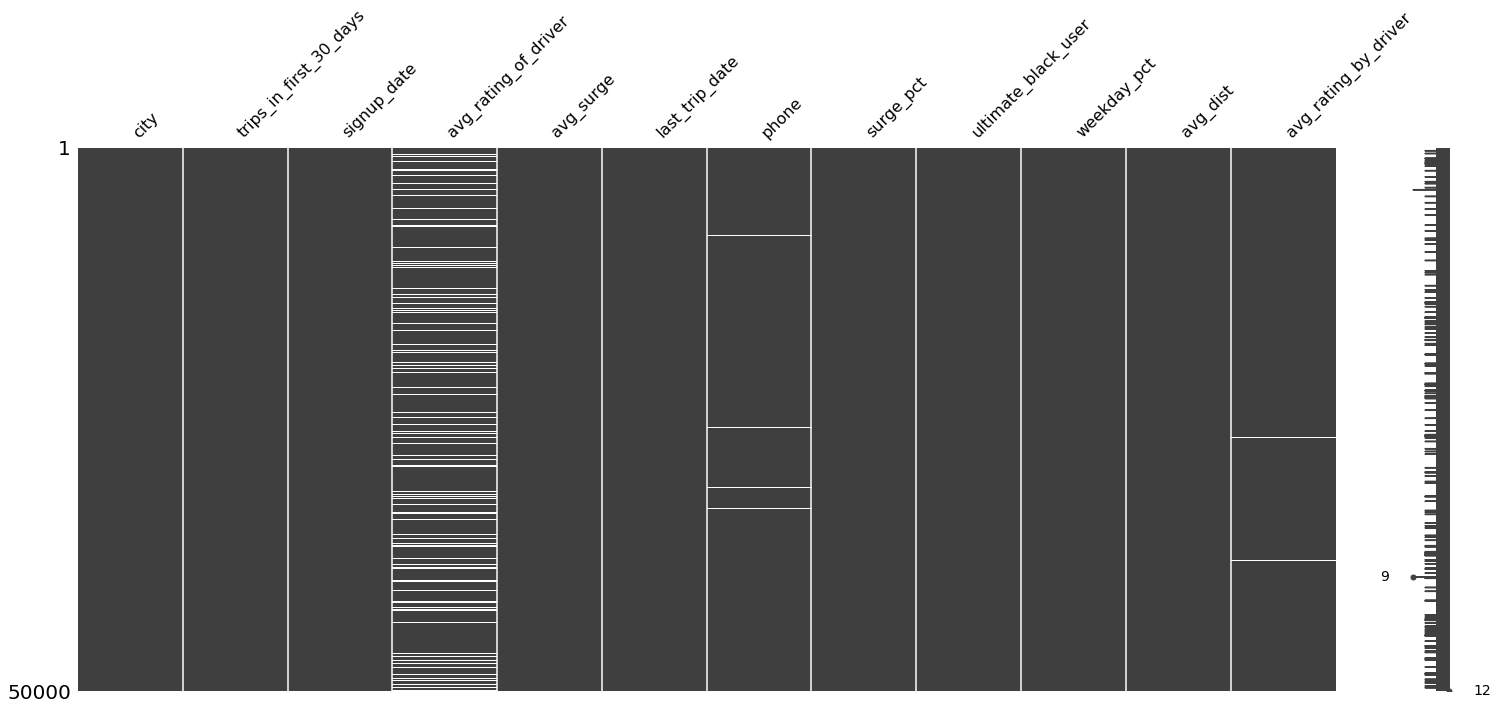

In [493]:
msno.matrix(data)

In [494]:
# Dropping null values
data.dropna(inplace=True)

In [495]:
data.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [496]:
data.shape

(41445, 12)

In [497]:
data['trips_in_first_30_days'].head()

0     4
1     0
2     3
3     9
4    14
Name: trips_in_first_30_days, dtype: int64

The target variable is last_trip_date

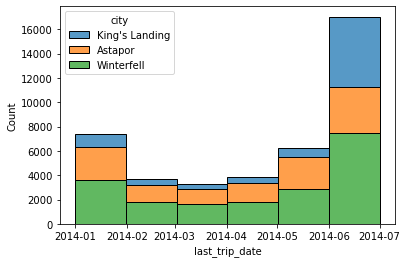

In [498]:
# The number of most recent trips from each city
sns.histplot(data=data, x='last_trip_date', hue='city', multiple='stack', bins=6)
plt.show()

<AxesSubplot:xlabel='last_trip_date', ylabel='Count'>

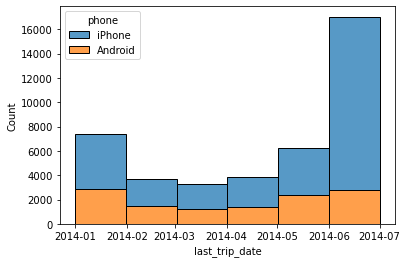

In [499]:
# The type of phone used of users who used the service most recently
sns.histplot(data=data, x='last_trip_date', hue='phone', multiple='stack', bins=6)

<AxesSubplot:xlabel='last_trip_date', ylabel='Count'>

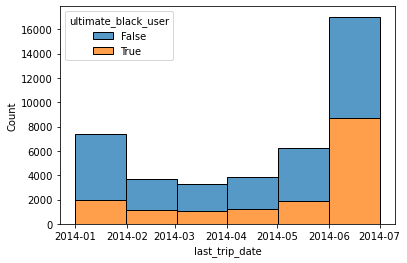

In [500]:
# The number of ultimate black users according to the most recent date
sns.histplot(data=data, x='last_trip_date', hue='ultimate_black_user', multiple='stack', bins=6)

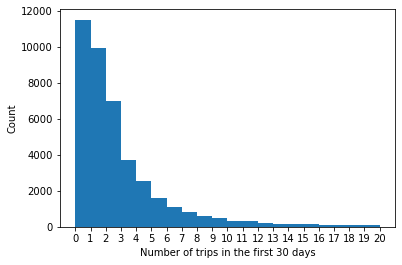

In [501]:
bins = range(0,21)
plt.hist(data.trips_in_first_30_days, bins=bins)
plt.xticks(bins)
plt.xlabel('Number of trips in the first 30 days')
plt.ylabel('Count')
plt.show()

Majority of trips have been taken in the last 30 days

In [502]:
data_resampled_month= data.set_index('last_trip_date').resample('M').sum()
data_resampled_month

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
last_trip_date,,,,,,,,
2014-01-31,14481,34158.5,7923.71,63628.7,1970,447551.8,47928.09,35493.2
2014-02-28,8232,15309.9,3644.70,32474.6,1004,203758.7,18916.14,15995.9
2014-03-31,5589,16358.7,3854.71,31316.2,1124,208411.5,19850.17,17009.8
2014-04-30,6150,17300.9,4004.08,29994.6,1225,232901.9,21319.59,17939.4
2014-05-31,12793,29348.6,6801.75,55646.6,1897,395208.8,34655.70,30441.2
2014-06-30,58053,75788.8,17707.08,150474.0,8428,1013786.8,81433.41,78559.1
2014-07-31,2860,2452.9,568.51,5272.3,271,37089.7,2188.52,2521.2


In [503]:
data['Month'] = data.last_trip_date.dt.month

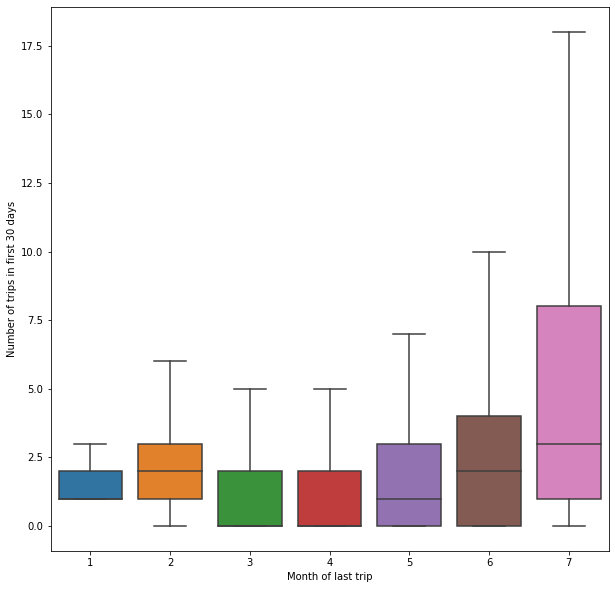

In [505]:
# The distribution of trips of users according to the month they last used the service
plt.figure(figsize=(10,10))
sns.boxplot(data=data, x=data.Month, y='trips_in_first_30_days', showfliers=False)
plt.xlabel('Month of last trip')
plt.ylabel('Number of trips in first 30 days')
plt.show()

In [506]:
data_resampled_month

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
last_trip_date,,,,,,,,
2014-01-31,14481,34158.5,7923.71,63628.7,1970,447551.8,47928.09,35493.2
2014-02-28,8232,15309.9,3644.70,32474.6,1004,203758.7,18916.14,15995.9
2014-03-31,5589,16358.7,3854.71,31316.2,1124,208411.5,19850.17,17009.8
2014-04-30,6150,17300.9,4004.08,29994.6,1225,232901.9,21319.59,17939.4
2014-05-31,12793,29348.6,6801.75,55646.6,1897,395208.8,34655.70,30441.2
2014-06-30,58053,75788.8,17707.08,150474.0,8428,1013786.8,81433.41,78559.1
2014-07-31,2860,2452.9,568.51,5272.3,271,37089.7,2188.52,2521.2


In [509]:
# Current date
data.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [510]:
data.last_trip_date.min()

Timestamp('2014-01-01 00:00:00')

In [511]:
# retainer daye = 30 days before the current date 
retainer_date = data.last_trip_date.max() - timedelta(days=30)
retainer_date

Timestamp('2014-06-01 00:00:00')

In [512]:
# Number of retained users 
retained = data[data.last_trip_date > retainer_date].count()[0]
retained

16608

In [513]:
# Number of total users
total_users = data.shape[0]
total_users

41445

In [514]:
retained_pct = retained/total_users

print('Percent of retained users: ', str(round(retained_pct*100)) + '%')

Percent of retained users:  40%


# 2.0 Predictive Modelling

## 2.1 Preprocesing

In [515]:
# 'in30' will be used as the target variable
data['in30'] = data.last_trip_date > retainer_date

In [516]:
retainer_date

Timestamp('2014-06-01 00:00:00')

In [517]:
data['in30']

0         True
1        False
2        False
3         True
4        False
         ...  
49993     True
49994    False
49995     True
49997    False
49998    False
Name: in30, Length: 41445, dtype: bool

In [518]:
# Transforming to binary
data['in30'] = data['in30'].astype('int')

In [519]:
data.in30

0        1
1        0
2        0
3        1
4        0
        ..
49993    1
49994    0
49995    1
49997    0
49998    0
Name: in30, Length: 41445, dtype: int64

In [520]:
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Month,in30
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,6,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,5,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,6,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,3,0


In [521]:
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Month,in30
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,6,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,5,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,6,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,3,0


In [522]:
# Converting signup date to days from first signup
delta = pd.Timestamp(data.signup_date.min())
delta

Timestamp('2014-01-01 00:00:00')

In [523]:
data['signup_in_days'] = data.signup_date - delta

In [524]:
data.signup_in_days = data.signup_in_days.dt.days.astype('int')

In [722]:
d2 = data.copy()

In [723]:
d2 = d2.drop(columns='Month')

In [724]:
d2.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,in30,signup_in_days
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1,24
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0,28
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0,5
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1,9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0,26


In [725]:
# Getting dummies for the cities
d2[['Astapor', "King's Landing", 'Winterfell']] = pd.get_dummies(d2.city)

In [726]:
d2.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,in30,signup_in_days,Astapor,King's Landing,Winterfell
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1,24,0,1,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0,28,1,0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0,5,1,0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1,9,0,1,0
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0,26,0,0,1


In [727]:
# Dropping city
d2.drop(columns='city', inplace=True)

In [728]:
d2.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,in30,signup_in_days,Astapor,King's Landing,Winterfell
0,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1,24,0,1,0
1,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0,28,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0,5,1,0,0
3,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1,9,0,1,0
4,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0,26,0,0,1


In [729]:
# Getting dummies for users' phones
d2[['Android', 'iPhone']] = pd.get_dummies(d2.phone)
d2

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,in30,signup_in_days,Astapor,King's Landing,Winterfell,Android,iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1,24,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0,28,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0,5,1,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1,9,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0,26,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,3,2014-01-03,4.8,1.11,2014-07-01,iPhone,11.1,True,55.6,2.53,4.7,1,2,1,0,0,0,1
49994,1,2014-01-03,4.6,1.44,2014-05-31,iPhone,37.5,False,25.0,2.25,4.5,0,2,1,0,0,0,1
49995,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,1,24,0,1,0,0,1
49997,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,0,30,0,0,1,1,0


In [730]:
# Making ultimate black user binary
d2['ultimate_black_user'] = d2['ultimate_black_user'].astype('int')

In [731]:
d2.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,in30,signup_in_days,Astapor,King's Landing,Winterfell,Android,iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,1,24,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,0,28,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,0,5,1,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1,9,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,0,26,0,0,1,1,0


In [732]:
# Dropping phone and date columns
d2 = d2.drop(columns=['signup_date', 'last_trip_date', 'phone'])

In [733]:
d2.shape

(41445, 15)

In [734]:
d2.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,in30,signup_in_days,Astapor,King's Landing,Winterfell,Android,iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,24,0,1,0,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,28,1,0,0,1,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,5,1,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,9,0,1,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,26,0,0,1,1,0


In [735]:
y = d2.in30.to_numpy()

In [736]:
X = d2.drop(columns='in30').to_numpy()

In [543]:
d2.drop(columns='in30').head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,signup_in_days,Astapor,King's Landing,Winterfell,Android,iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,24,0,1,0,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,28,1,0,0,1,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,5,1,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,9,0,1,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,26,0,0,1,1,0


In [610]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [612]:
[val.shape for val in [X_train, y_train, X_test, y_test]]

[(29011, 14), (29011,), (12434, 14), (12434,)]

In [614]:
# Scaling only the numeric values
scaler = StandardScaler()

X_train[:,:10] = scaler.fit_transform(X_train[:,:10])
X_test[:,:10] = scaler.transform(X_test[:,:10])
X[:,:10] = scaler.transform(X[:,:10])

## 2.2 Modelling

Recall will be used as a metric since it is most important in this scenario

In [642]:
np.random.seed(123)

In [648]:
# Function that returns scoring metrics
def scorer(model):
    model.fit(X_train, y_train)
    train_score = recall_score(model.predict(X_train), y_train)
    test_score = recall_score(model.predict(X_test), y_test)
    cv_score = cross_val_score(model, X, y, scoring='recall').mean()
    return train_score, test_score, cv_score

### 2.2.1 Dummy Model

In [708]:
dummy = DummyClassifier()

In [709]:
dummy.fit(X_train, y_train)

DummyClassifier()

In [710]:
dummy_train, dummy_test, dummy_cv_entire = scorer(dummy)

In [711]:
index = ['Train', 'Test', 'CV Entire']
knn_df = pd.DataFrame({'Dummy':[dummy_train, dummy_test, dummy_cv_entire]}, index=index)
knn_df

,Dummy
Train,0.0
Test,0.0
CV Entire,0.0


In [712]:
pd.DataFrame(classification_report(dummy.predict(X_test), y_test, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,1.000000,0.0,0.598842,0.500000,1.000000
recall,0.598842,0.0,0.598842,0.299421,0.598842
f1-score,0.749095,0.0,0.598842,0.374547,0.749095
support,12434.000000,0.0,0.598842,12434.000000,12434.000000


### 2.2.1 K Nearest Neighbors Classifier

#### 2.2.1.1 K Nearest Neighbors Default Model

In [616]:
knn = KNeighborsClassifier()

In [617]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [649]:
knn_train, knn_test, knn_cv_entire = scorer(knn)

In [650]:
index = ['Train', 'Test', 'CV Entire']
knn_df = pd.DataFrame({'KNN':[knn_train, knn_test, knn_cv_entire]}, index=index)
knn_df

,KNN
Train,0.776091
Test,0.669985
CV Entire,0.650109


In [651]:
pd.DataFrame(classification_report(knn.predict(X_test), y_test, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.786328,0.647554,0.730658,0.716941,0.732522
recall,0.769079,0.669985,0.730658,0.719532,0.730658
f1-score,0.777608,0.658579,0.730658,0.718093,0.731457
support,7613.000000,4821.000000,0.730658,12434.000000,12434.000000


We want to correctly classify all customers who do continue to use the service, therefore the precision of '1' is the metric that is most useful

#### 2.1.1.2 KNearest Neighbors Tuned Model

In [627]:
params = {'n_neighbors':[50,60,75,100,150], 'metric':['euclidian','minowski','manhattan','l1','l2']}
knn_cv = GridSearchCV(knn, param_grid=params, scoring='recall')

knn_cv.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidian', 'minowski', 'manhattan', 'l1',
                                    'l2'],
                         'n_neighbors': [50, 60, 75, 100, 150]},
             scoring='recall')

In [628]:
best_knn = knn_cv.best_estimator_
knn_cv.best_params_

{'metric': 'l2', 'n_neighbors': 75}

In [655]:
best_knn_train, best_knn_test, best_knn_cv_entire = scorer(best_knn)

In [656]:
best_knn_df = pd.DataFrame({'Random Forest':[best_knn_train, best_knn_test, best_knn_cv_entire]}, index=index)
best_knn_df

,Random Forest
Train,0.714638
Test,0.698490
CV Entire,0.663657


In [654]:
pd.DataFrame(classification_report(best_knn.predict(X_test), y_test, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.809562,0.658581,0.748995,0.734071,0.752455
recall,0.779718,0.698490,0.748995,0.739104,0.748995
f1-score,0.794360,0.677949,0.748995,0.736154,0.750329
support,7731.000000,4703.000000,0.748995,12434.000000,12434.000000


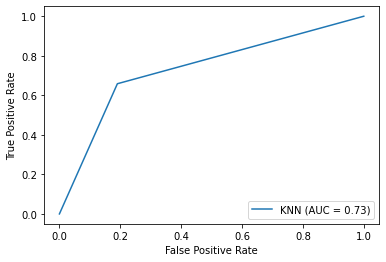

In [657]:
fpr, tpr, thresholds = roc_curve(y_test, best_knn.predict(X_test))
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='KNN')
display.plot()
plt.show()

## 2.2.2 Random Forest Classifier

### 2.2.2.1 Default Model

In [658]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [659]:
rf_test, rf_train, rf_cv_entire = scorer(rf)

In [713]:
rf_df = pd.DataFrame({'Random Forest':[rf_train, rf_test, rf_cv_entire]}, index=index)
rf_df

,Random Forest
Train,0.727979
Test,1.000000
CV Entire,0.679793


This model seems to be overfitting

### 2.2.2.2 Tuned Model

In [661]:
params = {'max_depth':[2,3,4,5,10,15], 'min_samples_split':[2,3,4]}
rf_cv = GridSearchCV(rf, param_grid=params, scoring='recall')

rf_cv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 10, 15],
                         'min_samples_split': [2, 3, 4]},
             scoring='recall')

In [663]:
best_rf = rf_cv.best_estimator_
best_rf

RandomForestClassifier(max_depth=15, min_samples_split=3)

In [664]:
best_rf_test, best_rf_train, best_rf_cv_entire = scorer(best_rf)

In [665]:
best_rf_df = pd.DataFrame({'Random Forest':[best_rf_train, best_rf_test, best_rf_cv_entire]}, index=index)
best_rf_df

,Random Forest
Train,0.739509
Test,0.902746
CV Entire,0.693100


In [666]:
pd.DataFrame(classification_report(best_rf.predict(X_test), y_test, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.839108,0.681836,0.776017,0.760472,0.780938
recall,0.797447,0.739509,0.776017,0.768478,0.776017
f1-score,0.817748,0.709502,0.776017,0.763625,0.777711
support,7835.000000,4599.000000,0.776017,12434.000000,12434.000000


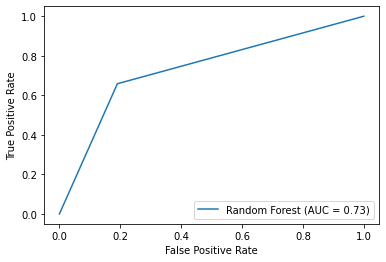

In [720]:
fpr, tpr, thresholds = roc_curve(y_test, best_knn.predict(X_test))
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest')
display.plot()
plt.show()

In [716]:
imps = best_rf.feature_importances_

In [717]:
d2.drop(columns='in30').shape

(41445, 14)

In [718]:
imps.shape

(14,)

<AxesSubplot:xlabel='Importances', ylabel='Features'>

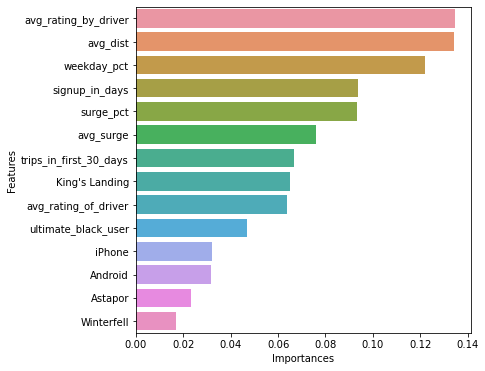

In [719]:
imps_df = pd.DataFrame({'Importances':imps, 'Features':d2.drop(columns='in30').columns})

plt.figure(figsize=(6,6))
sns.barplot(data=imps_df.sort_values(by='Importances', ascending=False), x='Importances', y='Features')

## 2.2.3 Logistic Regression

### 2.2.3.1 Default Logistic Regression

In [677]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [678]:
lr_test, lr_train, lr_cv_entire = scorer(lr)

In [679]:
index = ['Train', 'Test', 'CV Entire']
lr_df = pd.DataFrame({'Logistic Regression':[lr_train, lr_test, lr_cv_entire]}, index=index)
lr_df

,Logistic Regression
Train,0.670165
Test,0.674535
CV Entire,0.541848


### 2.2.3.2 Tuned Logistic Regression

In [690]:
params = {'C':[0.1,0.2,0.5,1.0], 'penalty':['l1', 'l2', 'elasticnet']}
lr_cv = GridSearchCV(lr, param_grid=params, scoring='recall')

lr_cv.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.2, 0.5, 1.0],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='recall')

In [691]:
best_lr = lr_cv.best_estimator_
best_lr

LogisticRegression()

In [687]:
best_lr_test, best_lr_train, best_lr_cv_entire = scorer(best_lr)

In [688]:
best_lr_df = pd.DataFrame({'Logistic Regression':[best_lr_train, best_lr_test, best_lr_cv_entire]}, index=index)
best_lr_df

,Logistic Regression
Train,0.670165
Test,0.674535
CV Entire,0.541848


In [680]:
imps = lr.coef_
imps = imps.flatten()

<AxesSubplot:xlabel='Importances', ylabel='Features'>

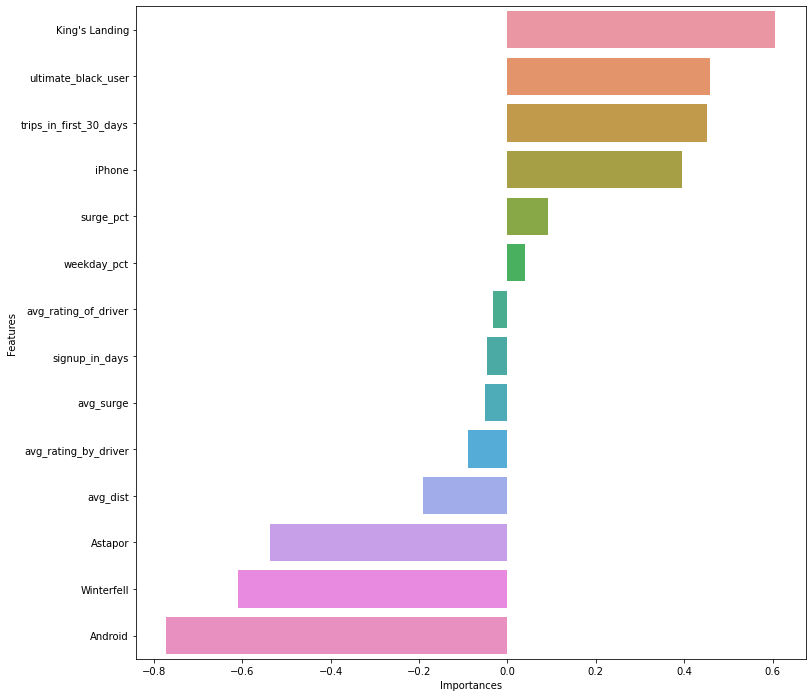

In [681]:
imps_df = pd.DataFrame({'Importances':imps, 'Features':d2.drop(columns='in30').columns})
plt.figure(figsize=(12,12))
sns.barplot(data=imps_df.sort_values(by='Importances', ascending=False), x='Importances', y='Features')

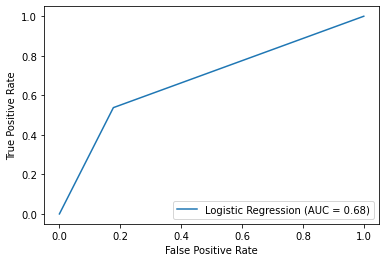

In [692]:
fpr, tpr, thresholds = roc_curve(y_test, best_lr.predict(X_test))
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display.plot()
plt.show()

In [714]:
final_df = pd.DataFrame({'Default KNN':[knn_test, knn_cv_entire], 'Tuned KNN':[best_knn_test, best_knn_cv_entire],\
            'Default Random Forest':[rf_test, rf_cv_entire], 'Tuned Random Forest':[best_rf_test, best_rf_cv_entire],
            'Default Logistic Regression':[lr_test, lr_cv_entire],\
            'Tuned Logistic Regression':[best_lr_test, best_lr_cv_entire]}, index=['Test', 'CV'])

final_df.T

,Test,CV
Default KNN,0.669985,0.650109
Tuned KNN,0.698490,0.663657
Default Random Forest,1.000000,0.679793
Tuned Random Forest,0.902746,0.693100
Default Logistic Regression,0.674535,0.541848
Tuned Logistic Regression,0.674535,0.541848
